In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

In [2]:
traindf_noisy=pd.read_csv('../input/freesound-audio-tagging-2019/train_noisy.csv',dtype=str)

traindf_curated=pd.read_csv('../input/freesound-audio-tagging-2019/train_curated.csv',dtype=str)

In [3]:
traindf_noisy.head()

,fname,labels
0,00097e21.wav,Bathtub_(filling_or_washing)
1,000b6cfb.wav,Motorcycle
2,00116cd2.wav,"Marimba_and_xylophone,Glockenspiel"
3,00127d14.wav,"Water_tap_and_faucet,Sink_(filling_or_washing)"
4,0019adae.wav,Raindrop


# Loading 0-K Fold Curated Train, CV and Test data

In [4]:
train_df = pd.read_csv("../input/sc2-total-aug-noisy-data/K_fold_data/K_fold_data/Curated/Curated_train_0.csv")
train_df.head()

,fname,labels
0,d349d1c7_aug.jpg,"Cutlery_and_silverware,Dishes_and_pots_and_pans"
1,e1c41fe6_aug.jpg,Burping_and_eructation
2,d8b54599.jpg,Accelerating_and_revving_and_vroom
3,15d94574_aug.jpg,Mechanical_fan
4,05be25ad.jpg,Shatter


In [5]:
train_df.shape

(6251, 2)

In [6]:
cv_df = pd.read_csv("../input/sc2-total-aug-noisy-data/K_fold_data/K_fold_data/Curated/Curated_cv_0.csv")
cv_df.shape

(1563, 2)

In [7]:
    
test_df = pd.read_csv("../input/sc2-total-aug-noisy-data/K_fold_data/K_fold_data/Curated/Curated_test.csv") 
test_df.shape

(1380, 2)

## Sklearn MultiLabelBinarizer to One-hot encode the multilablles 

In [8]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb_train = MultiLabelBinarizer()


labels_train = mlb_train.fit_transform([ i.split(",") for i in list(train_df["labels"])])


labels_test = mlb_train.transform([ i.split(",") for i in list(test_df["labels"])])


#mlb_cv = MultiLabelBinarizer()
labels_cv = mlb_train.transform([ i.split(",") for i in list(cv_df["labels"])])

In [9]:
labels_cv

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [10]:
trainmultidf=pd.DataFrame(data=labels_train,columns=list(mlb_train.classes_))
trainmultidf["fname"]=list(train_df["fname"])

testmultidf=pd.DataFrame(data=labels_test,columns=list(mlb_train.classes_))
testmultidf["fname"]=list(test_df["fname"])


cvmultidf=pd.DataFrame(data=labels_cv,columns=list(mlb_train.classes_))
cvmultidf["fname"]=list(cv_df["fname"])

In [11]:
cvmultidf.shape

(1563, 81)

In [12]:
testmultidf.head()

,Accelerating_and_revving_and_vroom,Accordion,Acoustic_guitar,Applause,Bark,Bass_drum,Bass_guitar,Bathtub_(filling_or_washing),Bicycle_bell,Burping_and_eructation,...,Traffic_noise_and_roadway_noise,Trickle_and_dribble,Walk_and_footsteps,Water_tap_and_faucet,Waves_and_surf,Whispering,Writing,Yell,Zipper_(clothing),fname
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,e9889c78.jpg
1,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,a06afbf0_aug.jpg
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,a9e97fb7.jpg
3,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,b855f490_aug.jpg
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,ec447208_aug.jpg


# Loading Preprocessed Spectrogram Images via ImageDataGenerator and adding augumnetation to train data

In [13]:
#We change the ids for the images in the csv files to reflect their new status as jpgs
#https://medium.com/@vijayabhaskar96/tutorial-on-keras-flow-from-dataframe-1fd4493d237c
from keras_preprocessing.image import ImageDataGenerator


datagen=ImageDataGenerator(rescale=1./255.,zoom_range=[0.5,1.0],brightness_range=[0.8,1.4])


train_generator=datagen.flow_from_dataframe(
    dataframe=trainmultidf,
    directory="../input/sc2-total-aug-noisy-data/Total images Bucket Curated/Total images Bucket Curated",
    x_col="fname",
    y_col=list(mlb_train.classes_),
    subset="training",
    batch_size=64,
    seed=42,
    shuffle=False,#True,
    class_mode="raw",
    color_mode="grayscale",
    target_size=(128,128))

Found 6251 validated image filenames.


In [14]:
train_generator.n

6251

In [15]:
cvmultidf.shape

(1563, 81)

In [16]:
valid_datagen=ImageDataGenerator(rescale=1./255.)

valid_generator=valid_datagen.flow_from_dataframe(
    dataframe=cvmultidf,
    directory="../input/sc2-total-aug-noisy-data/Total images Bucket Curated/Total images Bucket Curated",
    x_col="fname",
    y_col=list(mlb_train.classes_),
   # subset="validation",
    batch_size=64,
    seed=42,
    shuffle=False,#shuffle=True,
    class_mode="raw",
    color_mode="grayscale",
    target_size=(128,128))

Found 1563 validated image filenames.


In [17]:
test_datagen=ImageDataGenerator(rescale=1./255.)
test_generator=test_datagen.flow_from_dataframe(
    dataframe=testmultidf,
    directory="../input/sc2-total-aug-noisy-data/Total images Bucket Curated/Total images Bucket Curated",
    x_col="fname",
    y_col=None,
    batch_size=64,
    seed=42,
    shuffle=False,#shuffle=False,
    class_mode=None,
    color_mode="grayscale",
    target_size=(128,128))
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size

Found 1380 validated image filenames.


In [18]:
cvmultidf.head()

,Accelerating_and_revving_and_vroom,Accordion,Acoustic_guitar,Applause,Bark,Bass_drum,Bass_guitar,Bathtub_(filling_or_washing),Bicycle_bell,Burping_and_eructation,...,Traffic_noise_and_roadway_noise,Trickle_and_dribble,Walk_and_footsteps,Water_tap_and_faucet,Waves_and_surf,Whispering,Writing,Yell,Zipper_(clothing),fname
0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,9a93c380.jpg
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0ab47a4c.jpg
2,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,8f5bf633_aug.jpg
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,e07009c1.jpg
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,877562da_aug.jpg


# Loading Custom Model and Training

In [19]:
from sklearn import model_selection
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model

import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import sequence



import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.layers import Dense, Flatten, LSTM, Conv2D, MaxPooling2D, Dropout, Activation, Input,BatchNormalization, AveragePooling2D,GlobalMaxPool2D,PReLU

from tensorflow.keras.models import model_from_json  
from tensorflow.keras.applications import DenseNet169

from tensorflow.keras.callbacks import (ModelCheckpoint, LearningRateScheduler,
                             EarlyStopping, ReduceLROnPlateau,CSVLogger)

In [20]:
def convBlock(x, num_filter):
                                     conv1 = Conv2D(num_filter,1,
                                                    kernel_initializer=tf.keras.initializers.GlorotNormal(seed=42))(x)
                                                    
                                     conv1 = tf.keras.layers.LeakyReLU()(conv1)
                                     
                                     conv2 = Conv2D(num_filter,1,kernel_initializer=tf.keras.initializers.GlorotNormal(seed=48))(conv1)
                                     conv2 = BatchNormalization()(conv2)
                                     
                                     conv2 = tf.keras.layers.LeakyReLU()(conv2)
                                     
                                     block_add = layers.add([conv2, conv1])
                                     block_add = AveragePooling2D((2,2))(block_add)   


                                     return block_add

In [21]:
input = Input(shape=(128,128, 1))

x = convBlock(input,32)
x = convBlock(x,64)
x = convBlock(x,128)
x = convBlock(x,256)
x = convBlock(x,512)

x = BatchNormalization()(x)


#https://stackoverflow.com/questions/52934764/keras-adaptive-max-pooling
x = GlobalMaxPool2D()(x)
x = Dense(1024)(x)
x = PReLU()(x)
#x= Dropout(0.1)(x)
x = Dense(256)(x)
#x = Activation('relu')(x)
x = PReLU()(x)
x= Dense(80)(x)
output = Activation('sigmoid')(x)

model = Model(inputs=input,outputs=output)


## Training

In [22]:
opt = tf.keras.optimizers.Adam(lr=0.0009)#tf.keras.optimizers.RMSprop(lr=0.3, decay=1e-6) 
model.compile(loss=  tf.keras.losses.BinaryCrossentropy(reduction=tf.keras.losses.Reduction.SUM,
                                                        label_smoothing=0.7),#custom_loss_noisy_2,#custom_loss,#'categorical_crossentropy',
              optimizer=opt,
               metrics=['categorical_accuracy'])

In [23]:
model.get_weights()[0].shape

(1, 1, 1, 32)

In [24]:
#model.summary()

In [25]:
#tf.keras.utils.plot_model(model, 'discriminator.png', show_shapes=True)

In [26]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size

In [27]:
STEP_SIZE_TRAIN

97

In [28]:
model.load_weights("../input/sc2newfinalweights/Custom_2_total.best_weightsNoisy2BN.hdf5")

In [29]:
csv_logger = CSVLogger(filename='training_log.csv',
                       separator=',',
                       append=True)
#https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ReduceLROnPlateau
reduceLROnPlat = ReduceLROnPlateau(monitor='loss', factor=0.6,
                              patience=6, min_lr=0,verbose=1)


model_checkpoint = ModelCheckpoint("total.best_weightsNoisy2BN.hdf5", monitor='val_loss', mode='min', verbose=1, save_best_only=True)

# fit model

#es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20, min_delta=0.001 )
es = tf.keras.callbacks.EarlyStopping(monitor='val_categorical_accuracy', mode='max', verbose=1, patience=40, min_delta=0.001 )

In [30]:
import tensorflow as tf
import datetime, os

logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
callbacks_list = [model_checkpoint, csv_logger, reduceLROnPlat,tensorboard_callback,es]#es

In [31]:
%load_ext tensorboard
%tensorboard --logdir logs

In [32]:
STEP_SIZE_VALID

24

In [33]:
history=model.fit(train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=300,
                    callbacks=callbacks_list
)

Epoch 1/300
97/97 [==============================] - ETA: 0s - loss: 41.5528 - categorical_accuracy: 0.0205
Epoch 00001: val_loss improved from inf to 41.67288, saving model to total.best_weightsNoisy2BN.hdf5
97/97 [==============================] - 37s 384ms/step - loss: 41.5528 - categorical_accuracy: 0.0205 - val_loss: 41.6729 - val_categorical_accuracy: 0.0176
Epoch 2/300
97/97 [==============================] - ETA: 0s - loss: 41.5217 - categorical_accuracy: 0.0310
Epoch 00002: val_loss did not improve from 41.67288
97/97 [==============================] - 26s 266ms/step - loss: 41.5217 - categorical_accuracy: 0.0310 - val_loss: 41.7053 - val_categorical_accuracy: 0.0189
Epoch 3/300
97/97 [==============================] - ETA: 0s - loss: 41.5189 - categorical_accuracy: 0.0357
Epoch 00003: val_loss improved from 41.67288 to 41.64147, saving model to total.best_weightsNoisy2BN.hdf5
97/97 [==============================] - 26s 272ms/step - loss: 41.5189 - categorical_accuracy: 0.035

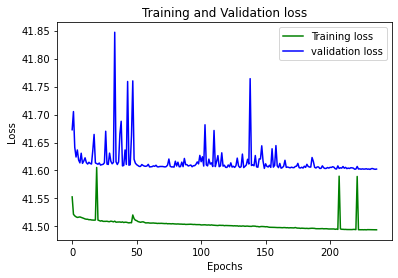

In [34]:
import matplotlib.pyplot as plt


loss_train = history.history['loss']
loss_val = history.history['val_loss']
#epochs = np.range(1,1)
plt.plot(loss_train, 'g', label='Training loss')
plt.plot(loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

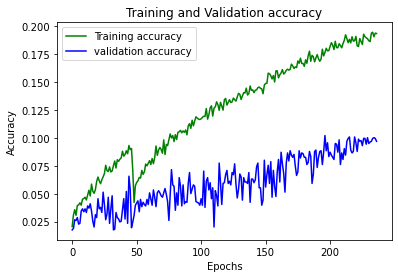

In [35]:
loss_train = history.history['categorical_accuracy']
loss_val = history.history['val_categorical_accuracy']
epochs = range(1,41)
plt.plot(loss_train, 'g', label='Training accuracy')
plt.plot(loss_val, 'b', label='validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [36]:
test_generator.reset()
res_test=model.predict_generator(test_generator,
#steps=STEP_SIZE_TEST,
verbose=1)

22/22 [==============================] - 4s 185ms/step


In [37]:
res_test.shape

(1380, 80)

In [38]:
valid_generator.reset()
res_cv=model.predict_generator(valid_generator,
#steps=STEP_SIZE_TEST,
verbose=1)

25/25 [==============================] - 3s 109ms/step


In [39]:
train_generator.reset()
res_train=model.predict_generator(train_generator,
#steps=STEP_SIZE_TEST,
verbose=1)

98/98 [==============================] - 21s 215ms/step


In [40]:
res_train.shape

(6251, 80)

In [41]:
res_train.shape

(6251, 80)

In [42]:
# Converting taget and identity columns to booleans

target_columns=list(trainmultidf.columns)[:-1]

def convert_to_bool(df, col_name):
    df[col_name] = np.where(df[col_name] >= 0.5, True, False)
    
def convert_dataframe_to_bool(df):
    bool_df = df.copy()
    for col in target_columns:
        convert_to_bool(bool_df, col)
    return bool_df

test_bool = convert_dataframe_to_bool(testmultidf) 
test_lable_bool=test_bool[list(test_bool.columns)[:-1]].to_numpy()

train_bool = convert_dataframe_to_bool(trainmultidf) 
train_lable_bool=train_bool[list(train_bool.columns)[:-1]].to_numpy()

cv_bool = convert_dataframe_to_bool(cvmultidf) 
cv_lable_bool=cv_bool[list(cv_bool.columns)[:-1]].to_numpy()

# Evaluation Metric

In [43]:
import numpy as np
import sklearn.metrics


def _one_sample_positive_class_precisions(scores, truth):
  """Calculate precisions for each true class for a single sample.
  
  Args:
    scores: np.array of (num_classes,) giving the individual classifier scores.
    truth: np.array of (num_classes,) bools indicating which classes are true.

  Returns:
    pos_class_indices: np.array of indices of the true classes for this sample.
    pos_class_precisions: np.array of precisions corresponding to each of those
      classes.
  """
  num_classes = scores.shape[0]
  pos_class_indices = np.flatnonzero(truth > 0)
  # Only calculate precisions if there are some true classes.
  if not len(pos_class_indices):
    return pos_class_indices, np.zeros(0)
  # Retrieval list of classes for this sample. 
  retrieved_classes = np.argsort(scores)[::-1]
  # class_rankings[top_scoring_class_index] == 0 etc.
  class_rankings = np.zeros(num_classes, dtype=np.int)
  class_rankings[retrieved_classes] = range(num_classes)
  # Which of these is a true label?
  retrieved_class_true = np.zeros(num_classes, dtype=np.bool)
  retrieved_class_true[class_rankings[pos_class_indices]] = True
  # Num hits for every truncated retrieval list.
  retrieved_cumulative_hits = np.cumsum(retrieved_class_true)
  # Precision of retrieval list truncated at each hit, in order of pos_labels.
  precision_at_hits = (
      retrieved_cumulative_hits[class_rankings[pos_class_indices]] / 
      (1 + class_rankings[pos_class_indices].astype(np.float)))
  return pos_class_indices, precision_at_hits

In [44]:
def calculate_per_class_lwlrap(truth, scores):
  """Calculate label-weighted label-ranking average precision.
  
  Arguments:
    truth: np.array of (num_samples, num_classes) giving boolean ground-truth
      of presence of that class in that sample.
    scores: np.array of (num_samples, num_classes) giving the classifier-under-
      test's real-valued score for each class for each sample.
  
  Returns:
    per_class_lwlrap: np.array of (num_classes,) giving the lwlrap for each 
      class.
    weight_per_class: np.array of (num_classes,) giving the prior of each 
      class within the truth labels.  Then the overall unbalanced lwlrap is 
      simply np.sum(per_class_lwlrap * weight_per_class)
  """
  assert truth.shape == scores.shape
  num_samples, num_classes = scores.shape
  # Space to store a distinct precision value for each class on each sample.
  # Only the classes that are true for each sample will be filled in.
  precisions_for_samples_by_classes = np.zeros((num_samples, num_classes))
  for sample_num in range(num_samples):
    pos_class_indices, precision_at_hits = (
      _one_sample_positive_class_precisions(scores[sample_num, :], 
                                            truth[sample_num, :]))
    precisions_for_samples_by_classes[sample_num, pos_class_indices] = (
        precision_at_hits)
  labels_per_class = np.sum(truth > 0, axis=0)
  weight_per_class = labels_per_class / float(np.sum(labels_per_class))
  # Form average of each column, i.e. all the precisions assigned to labels in
  # a particular class.
  per_class_lwlrap = (np.sum(precisions_for_samples_by_classes, axis=0) / 
                      np.maximum(1, labels_per_class))
  # overall_lwlrap = simple average of all the actual per-class, per-sample precisions
  #                = np.sum(precisions_for_samples_by_classes) / np.sum(precisions_for_samples_by_classes > 0)
  #           also = weighted mean of per-class lwlraps, weighted by class label prior across samples
  #                = np.sum(per_class_lwlrap * weight_per_class)
  return per_class_lwlrap, weight_per_class

In [45]:

def calculate_overall_lwlrap_sklearn(truth, scores):
  """Calculate the overall lwlrap using sklearn.metrics.lrap."""
  # sklearn doesn't correctly apply weighting to samples with no labels, so just skip them.
  sample_weight = np.sum(truth > 0, axis=1)
  nonzero_weight_sample_indices = np.flatnonzero(sample_weight > 0)
  overall_lwlrap = sklearn.metrics.label_ranking_average_precision_score(
      truth[nonzero_weight_sample_indices, :] > 0, 
      scores[nonzero_weight_sample_indices, :], 
      sample_weight=sample_weight[nonzero_weight_sample_indices])
  return overall_lwlrap

In [46]:
class lwlrap_accumulator(object):
  """Accumulate batches of test samples into per-class and overall lwlrap."""  

  def __init__(self):
    self.num_classes = 0
    self.total_num_samples = 0
  
  def accumulate_samples(self, batch_truth, batch_scores):
    """Cumulate a new batch of samples into the metric.
    
    Args:
      truth: np.array of (num_samples, num_classes) giving boolean
        ground-truth of presence of that class in that sample for this batch.
      scores: np.array of (num_samples, num_classes) giving the 
        classifier-under-test's real-valued score for each class for each
        sample.
    """
    assert batch_scores.shape == batch_truth.shape
    num_samples, num_classes = batch_truth.shape
    if not self.num_classes:
      self.num_classes = num_classes
      self._per_class_cumulative_precision = np.zeros(self.num_classes)
      self._per_class_cumulative_count = np.zeros(self.num_classes, 
                                                  dtype=np.int)
    assert num_classes == self.num_classes
    for truth, scores in zip(batch_truth, batch_scores):
      pos_class_indices, precision_at_hits = (
        _one_sample_positive_class_precisions(scores, truth))
      self._per_class_cumulative_precision[pos_class_indices] += (
        precision_at_hits)
      self._per_class_cumulative_count[pos_class_indices] += 1
    self.total_num_samples += num_samples

  def per_class_lwlrap(self):
    """Return a vector of the per-class lwlraps for the accumulated samples."""
    return (self._per_class_cumulative_precision / 
            np.maximum(1, self._per_class_cumulative_count))

  def per_class_weight(self):
    """Return a normalized weight vector for the contributions of each class."""
    return (self._per_class_cumulative_count / 
            float(np.sum(self._per_class_cumulative_count)))

  def overall_lwlrap(self):
    """Return the scalar overall lwlrap for cumulated samples."""
    return np.sum(self.per_class_lwlrap() * self.per_class_weight())

In [47]:
#https://www.kaggle.com/voglinio/keras-2d-model-5-fold-log-specgram-curated-only
truth = test_lable_bool
scores = res_test
print("lwlrap from sklearn.metrics =", calculate_overall_lwlrap_sklearn(truth, scores))

lwlrap from sklearn.metrics = 0.2220629950003967


In [48]:
truth = train_lable_bool
scores = res_train
print("lwlrap from sklearn.metrics =", calculate_overall_lwlrap_sklearn(truth, scores))

lwlrap from sklearn.metrics = 0.34433522350224083


In [49]:
truth = cv_lable_bool
scores = res_cv
print("lwlrap from sklearn.metrics =", calculate_overall_lwlrap_sklearn(truth, scores))

lwlrap from sklearn.metrics = 0.22868170238282937


# Submission

In [50]:
sub_dataframe = pd.DataFrame({'fname':os.listdir('../input/sc2-total-aug-noisy-data/sub2/sub2')})

In [51]:
sub_datagen=ImageDataGenerator(rescale=1./255.)
sub_generator=sub_datagen.flow_from_dataframe(
    dataframe=sub_dataframe,
    directory="../input/sc2-total-aug-noisy-data/sub2/sub2",
    x_col="fname",
    y_col=None,
    batch_size=64,
    seed=42,
    shuffle=False,#shuffle=False,
    class_mode=None,
    color_mode="grayscale",
    target_size=(128,128))
STEP_SIZE_SUB=sub_generator.n//sub_generator.batch_size

Found 3361 validated image filenames.


In [52]:
sub_generator.reset()
res_sub=model.predict_generator(sub_generator,
#steps=STEP_SIZE_TEST,
verbose=1)

53/53 [==============================] - 11s 207ms/step


In [53]:
submit_data=pd.DataFrame(res_sub.astype("float64"), columns=list(mlb_train.classes_))

In [54]:
submit_data.insert(0, 'fname', os.listdir('../input/sc2-total-aug-noisy-data/sub2/sub2'))
submit_data["fname"]=submit_data["fname"].apply(lambda x: x.split(".")[0]+".wav")
submit_data.head()

,fname,Accelerating_and_revving_and_vroom,Accordion,Acoustic_guitar,Applause,Bark,Bass_drum,Bass_guitar,Bathtub_(filling_or_washing),Bicycle_bell,...,Toilet_flush,Traffic_noise_and_roadway_noise,Trickle_and_dribble,Walk_and_footsteps,Water_tap_and_faucet,Waves_and_surf,Whispering,Writing,Yell,Zipper_(clothing)
0,53cefef0.wav,0.346481,0.351873,0.346637,0.352271,0.349168,0.366126,0.347189,0.351332,0.405199,...,0.351133,0.351358,0.350390,0.351016,0.352038,0.346159,0.351702,0.349679,0.349258,0.352273
1,63b41f09.wav,0.349181,0.354293,0.396450,0.350703,0.352679,0.348850,0.351810,0.364183,0.354378,...,0.352159,0.357297,0.354791,0.349025,0.368260,0.353365,0.342081,0.340141,0.346909,0.350295
2,9da3bbc9.wav,0.351659,0.349719,0.346252,0.352661,0.349353,0.348353,0.354356,0.353510,0.348553,...,0.355527,0.351215,0.357203,0.354910,0.348584,0.350091,0.349533,0.357303,0.354594,0.346603
3,b6e192f8.wav,0.360171,0.349143,0.351196,0.351163,0.357307,0.352828,0.350358,0.369143,0.357907,...,0.348489,0.351874,0.357501,0.351153,0.366923,0.346773,0.341868,0.336726,0.350900,0.355026
4,f2ebd17a.wav,0.351671,0.351150,0.347524,0.351846,0.360044,0.358940,0.350322,0.350472,0.356367,...,0.348898,0.350655,0.349155,0.354011,0.353215,0.350979,0.356401,0.352485,0.349758,0.348032


In [55]:
submit_data.to_csv("submission_AugNoisyData_selfNoisy1.csv",index=False )